```
 Name: 張宸愷
 ID: 0710018
```


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

mush = pd.read_csv("data/agaricus-lepiota.data", sep=",", header=None)
mush = mush.drop(columns=11)  # drop features with with missing values

# encode the categorical features
encoder = OrdinalEncoder(dtype=np.int8)
encoder.fit(mush)
data = encoder.transform(mush)  # encode the dataset into integers

# np.random.shuffle(data)

# The one I wrote myself
def get_metrics(confm: np.ndarray):
    tn, fp, fn, tp = confm
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tn + tp + fn + fn)

    return sensitivity, precision, accuracy


def single_run(training: np.ndarray, validation: np.ndarray):
    cat_NB = CategoricalNB(
        alpha=1e-10,
        min_categories=[6, 4, 10, 2, 9, 4, 3, 2, 12, 2, 4, 4, 9, 9, 2, 4, 3, 8, 9, 6, 7])
    cat_NB.fit(training[:, 1:], training[:, 0])

    prediction = cat_NB.predict(validation[:, 1:])
    validation = encoder.inverse_transform(validation) # get back the category labels
    mod_pred = np.zeros(validation.shape)
    mod_pred[:, 0] = prediction # insert them into a fake ndarray with the same shape
                                # so that we can do the inverse transform
    mod_pred = encoder.inverse_transform(mod_pred) # get back the labels
    confm = confusion_matrix(validation[:, 0], mod_pred[:, 0], labels=["p", "e"])
    r = classification_report(
        validation[:, 0], mod_pred[:, 0], digits=8, output_dict=True)

    return confm, r


def print_metrics(r: dict(), confm:np.ndarray, name:str=""):
    print(name)
    print("""
    | category | recall | precision | accuracy |
    |----|----|----|----|
    | p | {} | {} | {} |
    | e | {} | {} | {} |
      """.format(r["p"]["recall"], r["p"]["precision"], r["accuracy"],
                 r["e"]["recall"], r["e"]["precision"], r["accuracy"]))
    print("""
    | category | recall | precision | accuracy |
    |----|----|----|----|
    | p(true) | {} | {} | {} |
    | e(true) | {} | {} | {} |    
    
    """)

mode = "holdout"
training = data.copy()

if mode == "holdout":

    ratio = 0.7
    # split data 7:3
    validation = training[int(training.shape[0]*ratio):].copy()
    training = training[0:int(training.shape[0]*ratio)]
    # train and validate
    confm, r = single_run(training, validation)

else:
    kf = KFold(n_splits=3)
    sum = []
    for train_i, valid_i in kf.split(X=training[:, 1:]):
        # train and validate
        confm = single_run(
            training[train_i], training[valid_i])
        sum.append(confm)
    confm = np.sum(sum, axis=0) / 3 # average the confusion matrix

print("tn, fp, fn, tp =", confm)
print_metrics(r)


    | category | recall | precision | accuracy |
    |----|----|----|----|
    | p | 1.0 | 0.9195171026156942 | 0.9343724364232978 |
    | e | 0.7377049180327869 | 1.0 | 0.9343724364232978 |
      
tn, fp, fn, tp = [[1828    0]
 [ 160  450]]


  
  # No smoothing
  
  | category | recall | precision | accuracy |
  |----|----|----|----|
  | p | 0.9991511035653651 | 0.9957698815566836 | 0.9975389663658737 |
  | e | 0.996031746031746 | 0.9992038216560509 | 0.9975389663658737 |
      

      

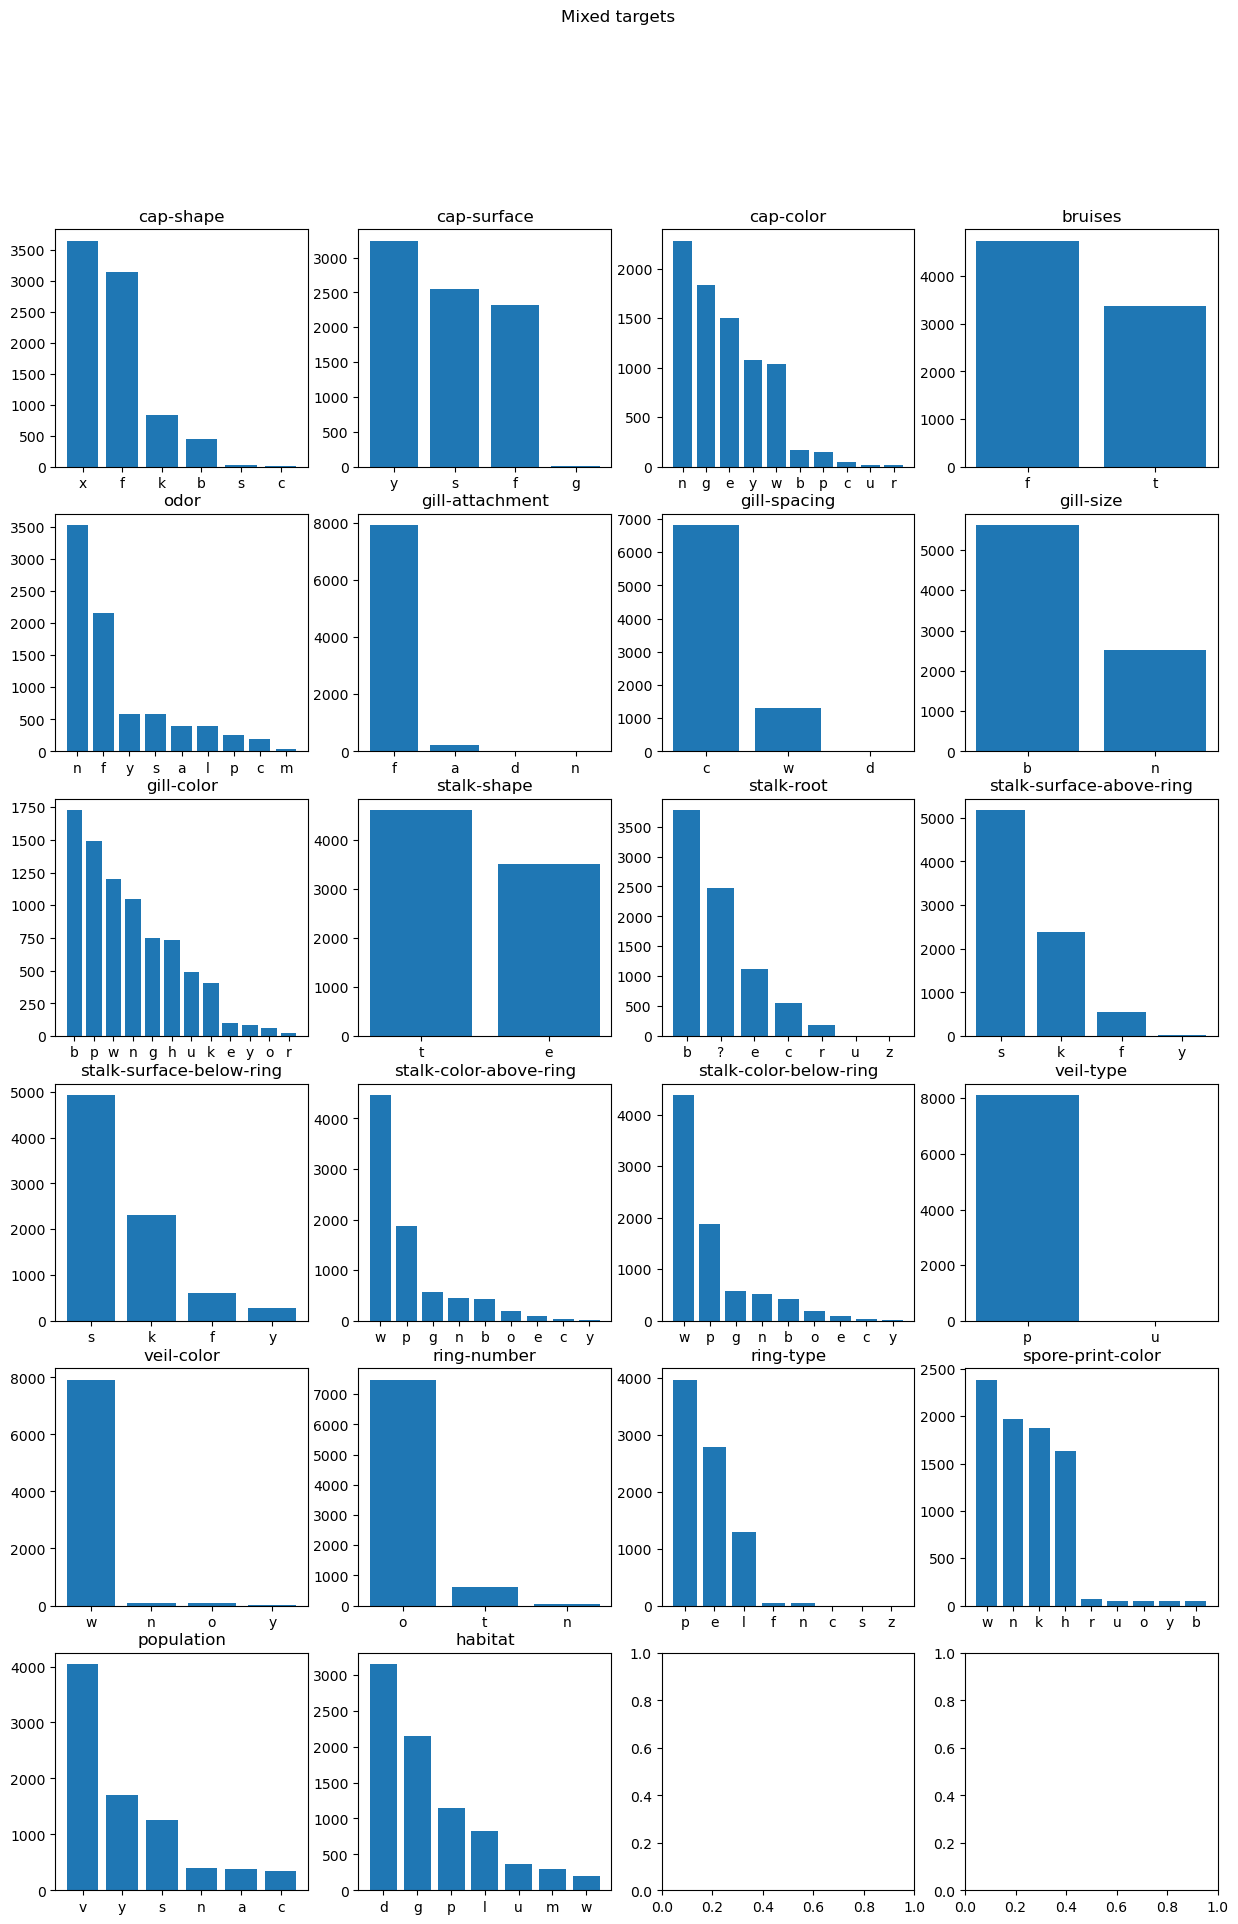

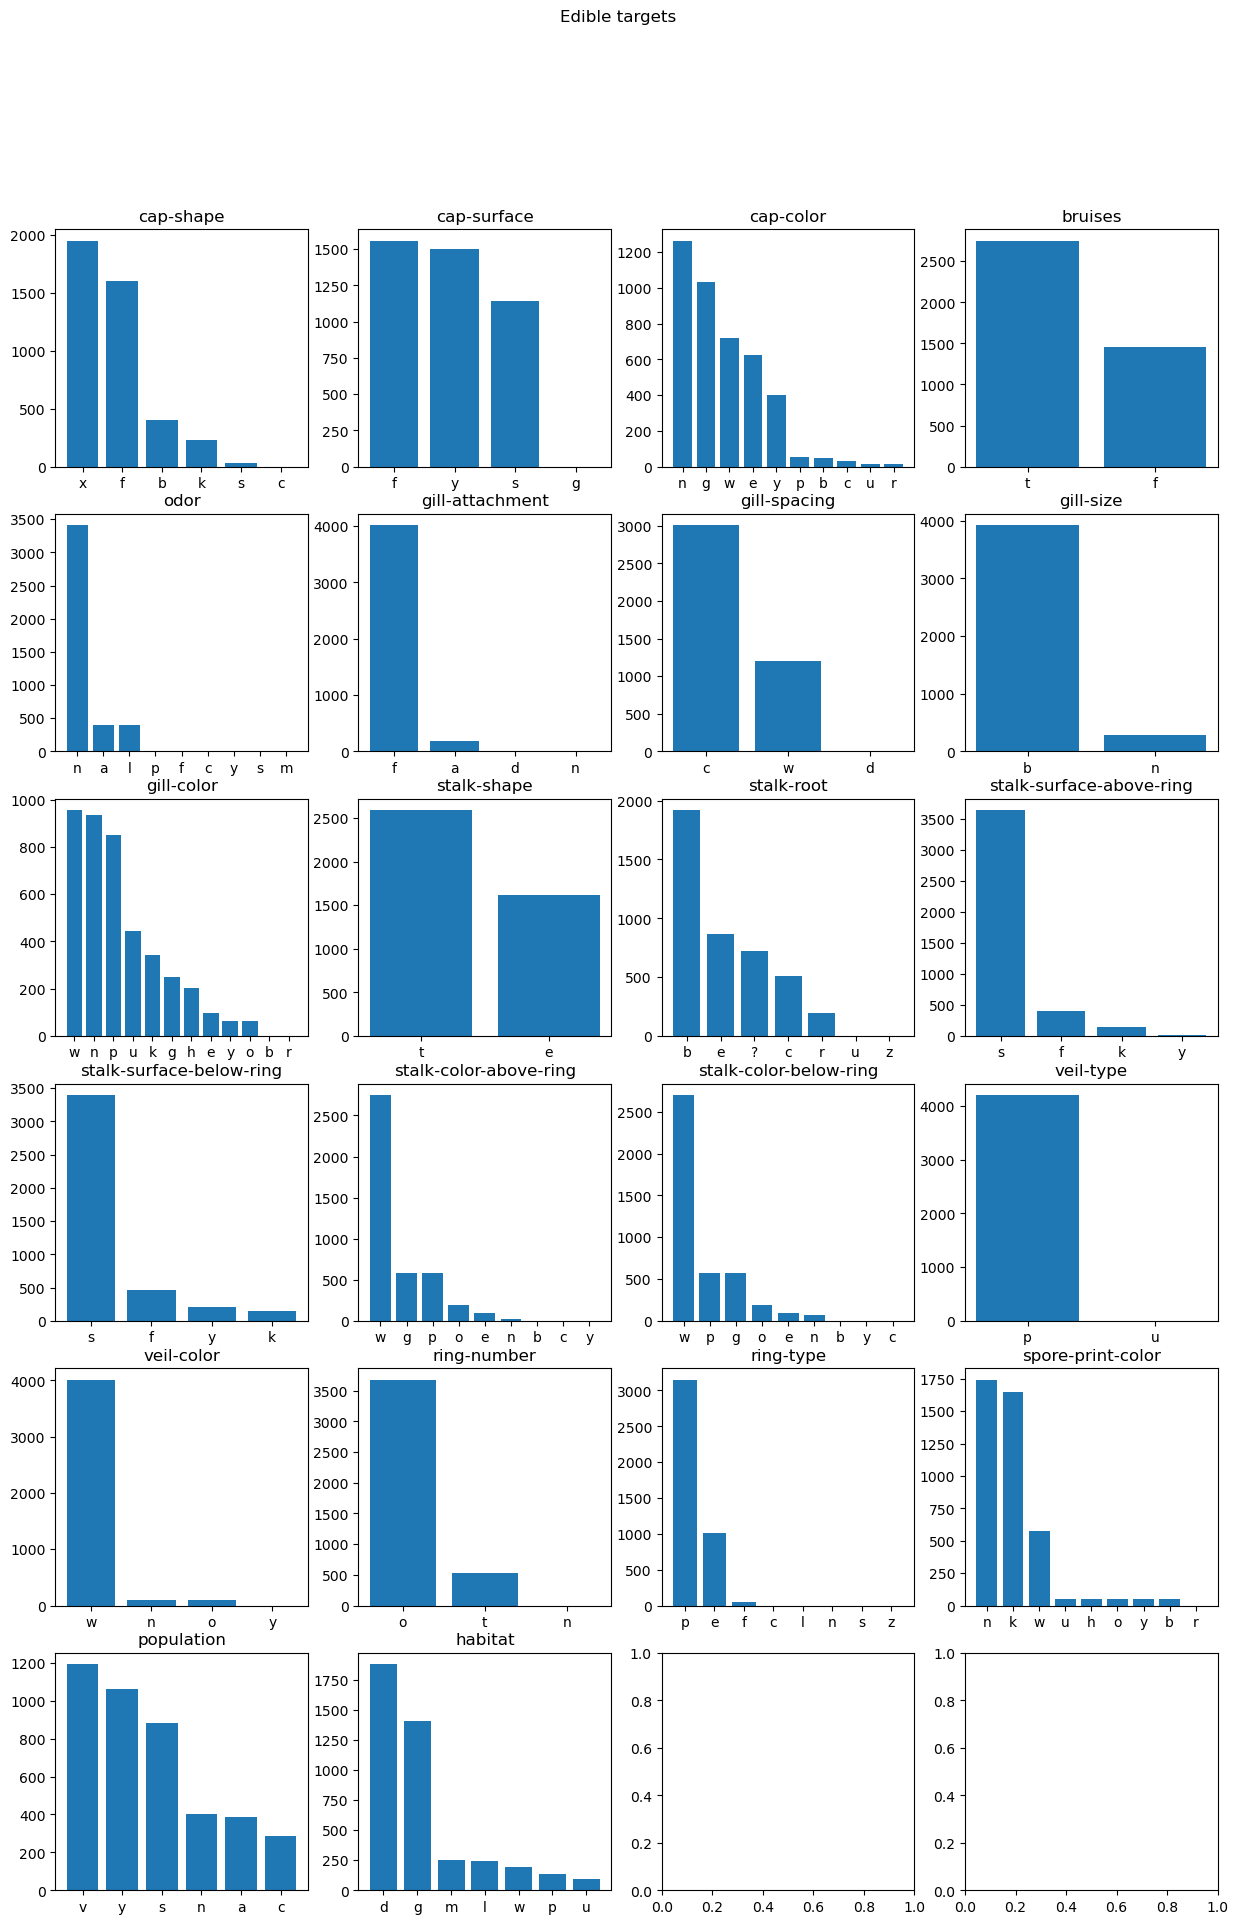

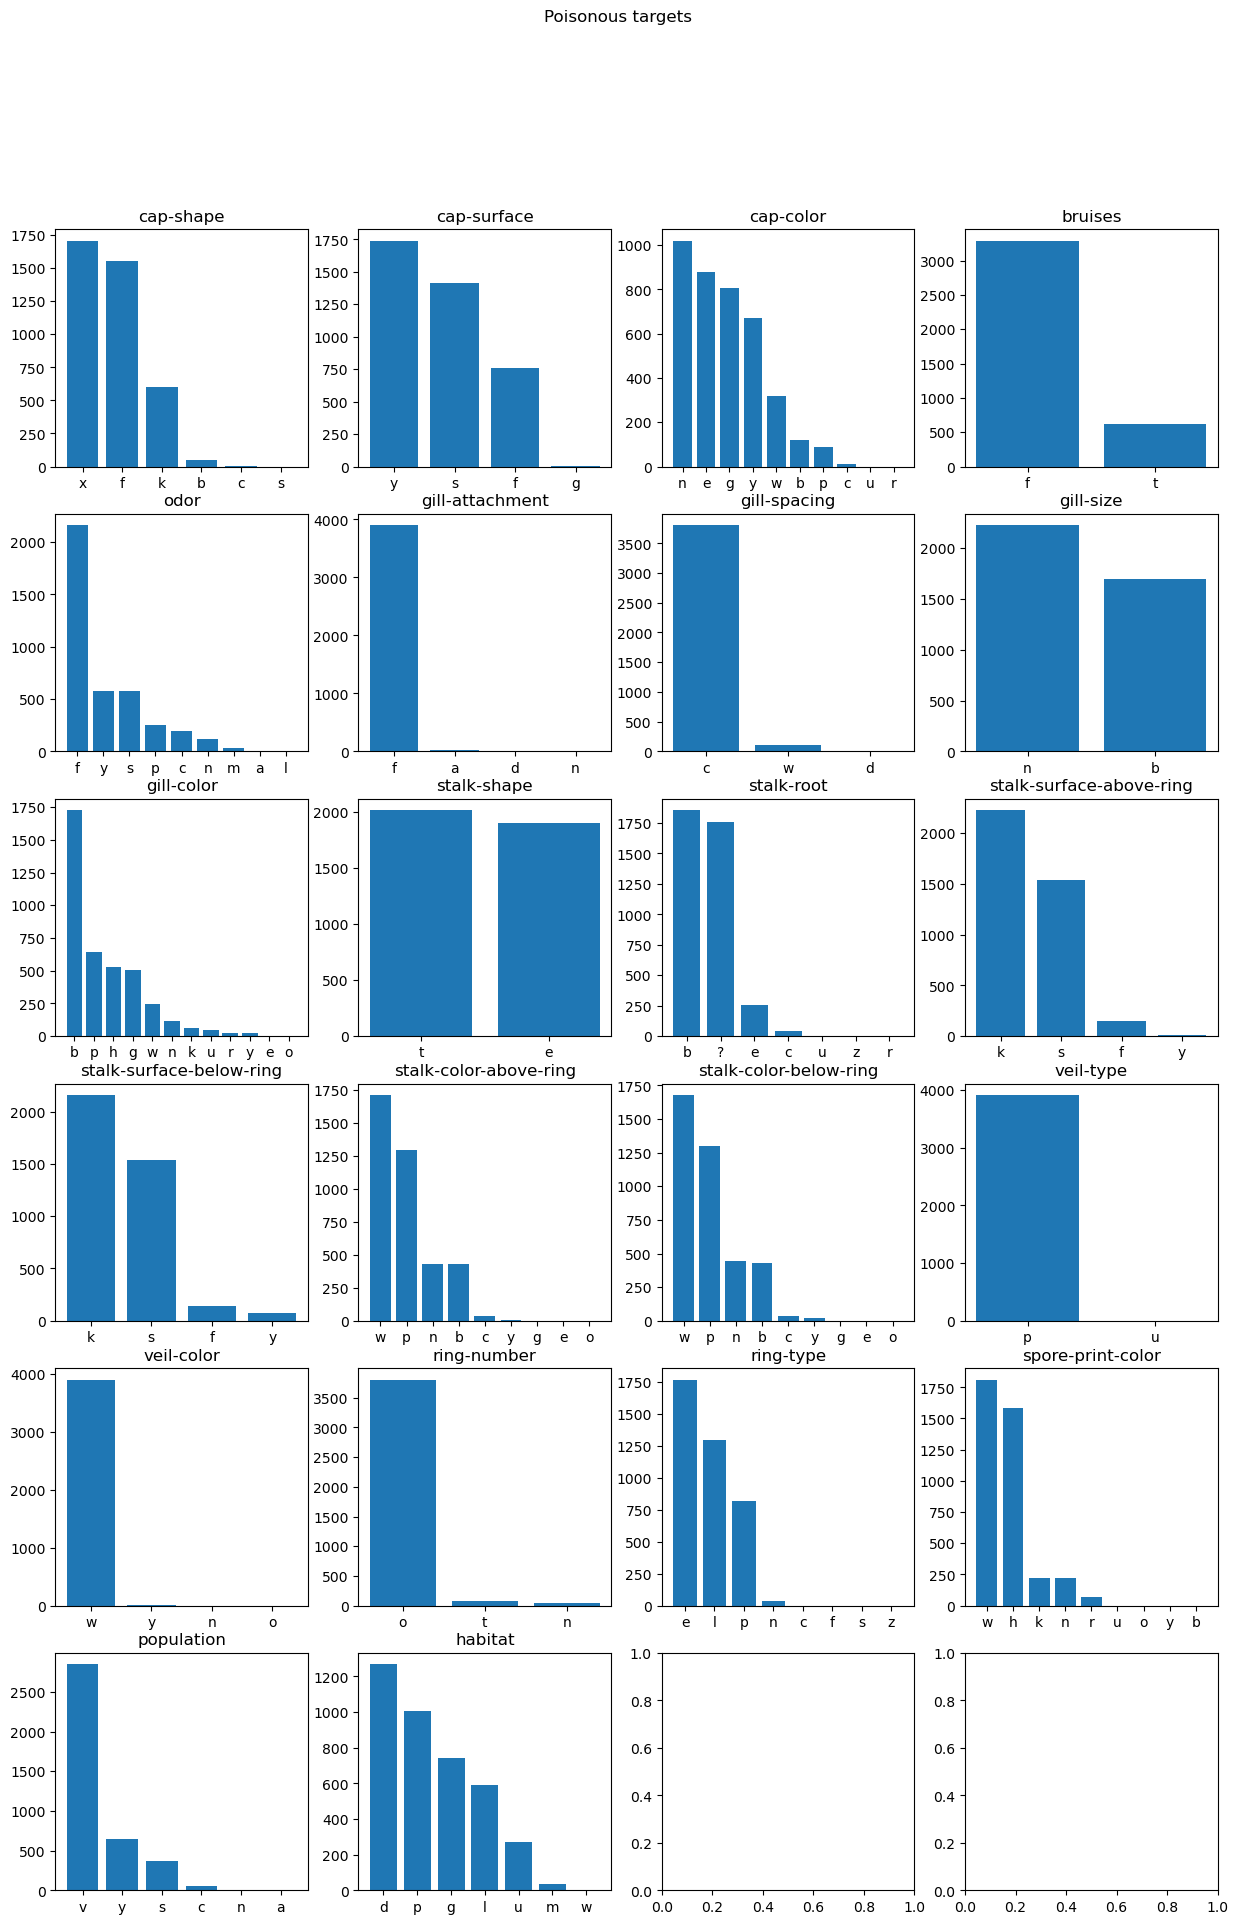

In [24]:
# data visualization

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

visual_data: pd.DataFrame = pd.read_csv(
    "data/agaricus-lepiota.data", sep=",", header=None)

titles = ["cap-shape",
          "cap-surface",
          "cap-color",
          "bruises",
          "odor",
          "gill-attachment",
          "gill-spacing",
          "gill-size",
          "gill-color",
          "stalk-shape",
          "stalk-root",
          "stalk-surface-above-ring",
          "stalk-surface-below-ring",
          "stalk-color-above-ring",
          "stalk-color-below-ring",
          "veil-type",
          "veil-color",
          "ring-number",
          "ring-type",
          "spore-print-color",
          "population",
          "habitat"]

generate_graph = True

if (generate_graph):
    zero_instance = {6: ['a', 'd', 'f', 'n'], 7: ['c', 'w', 'd'], 11: [
        'b', 'c', 'u', 'e', 'z', 'r', '?'], 16: ['p', 'u'], 19: ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z']}

    # plot mixed
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Mixed targets")

    # plot edible
    selector = visual_data[0] == 'e'
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Edible targets")

    # plot poisonous
    selector = visual_data[0] == 'p'
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Poisonous targets")



    

   1.000000e-10  1.000000e+02  1.000000e+03  2.000000e+03
w  6.425856e-01      0.548943      0.280436      0.211816
p  1.368821e-01      0.132341      0.119322      0.115994
g  1.368821e-01      0.132341      0.119322      0.115994
o  4.562738e-02      0.057165      0.090248      0.098703
e  2.281369e-02      0.038371      0.082980      0.094380
n  1.520913e-02      0.032106      0.080557      0.092939
b  2.376426e-14      0.019577      0.075712      0.090058
c  2.376426e-14      0.019577      0.075712      0.090058
y  2.376426e-14      0.019577      0.075712      0.090058


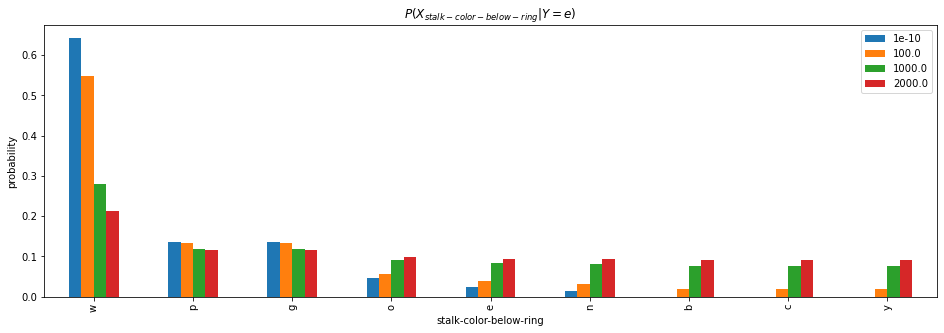

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

generate_graph = True

visual_data: pd.DataFrame = pd.read_csv(
    "data/agaricus-lepiota.data", sep=",", header=None)


def laplace(alpha=1e-10):
    edible_sel = visual_data[0] == 'e'
    edible = visual_data[edible_sel]
    edible_y = edible.shape[0]

    es = edible[15].value_counts(sort=False).reindex(
        ['w', 'p', 'n', 'b', 'c', 'y', 'g', 'e', 'o'], fill_value=0).sort_values(ascending=False)
    tau = 9
    # print(es.index)
    vals = dict()
    for i in es.index:
        vals[i] = (es[i] + alpha) / (edible_y + tau * alpha)
    # print(vals)
    return vals


if(generate_graph):

    ls = [1e-10, 100, 1000, 2000]
    vals:list = []
    for i in range(4):
        v = laplace(ls[i])
        vals.append(v)
    def trans(name):
        return ls[name]
    df = pd.DataFrame(vals).rename(mapper=trans).T

    print(df)
    df.plot.bar(figsize=(16, 5))
    
    plt.title("$P(X_{stalk-color-below-ring} | Y = e)$")
    plt.xlabel("stalk-color-below-ring")
    plt.ylabel("probability")